In [1]:
using FITSIO, ProgressBars, Statistics, Interpolations, Serialization, PyPlot, Optim

Throughout this notebook, I've avoided non-`const` globals for performance reasons.

In [2]:
const param_names = ["teff", "logg", "metallicity", "alpha", "C", "N", "vdop"] #not actually used anywhere

#note that the grid extends from llimits to ulimits - steps, not from llimits to ulimits.  
#That's how it is in the FERRE headers.
const llimits = [3500., 0., -2.5, -0.75, -1.5, -0.5, -0.52288]
const steps   = [250, 0.5, 0.25, 0.25, 0.25, 0.5, 0.30103]
const ulimits = [6250, 5.0, 1.25, 1.25, 1.25, 2.5, 0.98227]
const ranges = (:).(llimits, steps, ulimits .- steps)
;

To generate the file containing a serialized array of interpolators, uncomment and execute the next 3 cells, changing file names as appropriate

In [3]:
#=
#We are not going to bother interpolating a bunch of NaNs.
const nanmask = .! isnan.(FITS(read ∘ first, "/moto/astro/projects/APOGEE_grid/ap05cp08np00vp24.fits")[:, 1, 1, 1])

const grid = Array{Float32}(undef, sum(nanmask), length.(ranges)...);
function fillgrid!(grid)
    fnsegments = ["a" .* ["m08","m05","m03","p00","p03","p05","p08","p10"], 
              "c" .* ["m03","m05","m08","m10","m13","m15","p00","p03","p05","p08","p10"],
              "n" .* ["m05", "p00", "p05", "p10","p15","p20"],  
              "v" .* ["p03","p06","p12","p24","p48"]]

    for I in ProgressBar(CartesianIndices(Tuple(length.(fnsegments))))
        fn = "/moto/astro/projects/APOGEE_grid/"* *(getindex.(fnsegments, Tuple(I))...) *".fits"
        grid[:, :, :, :, I] .= FITS(read ∘ first, fn)[nanmask, :, :, :]
    end  
end
fillgrid!(grid)
=#

In [4]:
#=
#trim(r) = r[2:end-1]
itps = map(ProgressBar(1:size(grid, 1))) do λ
    subgrid = grid[λ, :, :, :, :, :, :, :]
    scale(interpolate(subgrid, BSpline(Cubic(Reflect(OnGrid())))), (ranges)...) 
end
;
=#

In [5]:
#using Serialization
#serialize("../data/apogee_grid_interpolator_notrim.jdb", itps)

In [6]:
const itps = deserialize("../data/apogee_grid_interpolator_notrim.jdb");

In [7]:
interpolate_spectrum(x) = [itp(x...) for itp in itps]
function interpolate_jacobi(x)
    J = Matrix(undef, length(itps), length(x))
    for (λ, itp) in enumerate(itps)
        Interpolations.gradient!(view(J,λ,:), itp, x...)
    end
    J
end

interpolate_jacobi (generic function with 1 method)

Plot an interpolated spectrum at a random point in parameter space, and time the calls to `interpolate_spectrum` and `interpolate_jacobi`. The first time you execute this, it will just-in-time compile, which takes a really long time (literally 25 miutes!) for some reason.  After that, it's fast.

In [9]:
function time_itp()
    x = rand(7) .* (ulimits-steps-llimits) + llimits
    @time interpolate_spectrum(x);
    @time interpolate_jacobi(x)
end
time_itp();

  0.513343 seconds (62.03 k allocations: 1.006 MiB)
  0.650560 seconds (124.05 k allocations: 2.898 MiB)


In [12]:
using Distributed
addprocs(4)

4-element Array{Int64,1}:
 2
 3
 4
 5

In [14]:
x = rand(7) .* (ulimits-steps-llimits) + llimits
specs = pmap(1:4) do i
    x += randn(7) .* steps ./ 100
    interpolate_spectrum(x)
end
for spec in specs
    plot(spec)
end

LoadError: On worker 2:
UndefVarError: #interpolate_spectrum not defined
deserialize_datatype at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.5/Serialization/src/Serialization.jl:1252
handle_deserialize at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.5/Serialization/src/Serialization.jl:826
deserialize at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.5/Serialization/src/Serialization.jl:773
handle_deserialize at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.5/Serialization/src/Serialization.jl:833
deserialize at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.5/Serialization/src/Serialization.jl:773 [inlined]
deserialize_global_from_main at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.5/Distributed/src/clusterserialize.jl:180
#3 at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.5/Distributed/src/clusterserialize.jl:72 [inlined]
foreach at ./abstractarray.jl:2009
deserialize at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.5/Distributed/src/clusterserialize.jl:72
handle_deserialize at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.5/Serialization/src/Serialization.jl:919
deserialize at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.5/Serialization/src/Serialization.jl:773
handle_deserialize at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.5/Serialization/src/Serialization.jl:830
deserialize at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.5/Serialization/src/Serialization.jl:773
handle_deserialize at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.5/Serialization/src/Serialization.jl:833
deserialize at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.5/Serialization/src/Serialization.jl:773 [inlined]
deserialize_msg at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.5/Distributed/src/messages.jl:99
#invokelatest#1 at ./essentials.jl:710 [inlined]
invokelatest at ./essentials.jl:709 [inlined]
message_handler_loop at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.5/Distributed/src/process_messages.jl:185
process_tcp_streams at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.5/Distributed/src/process_messages.jl:142
#99 at ./task.jl:356

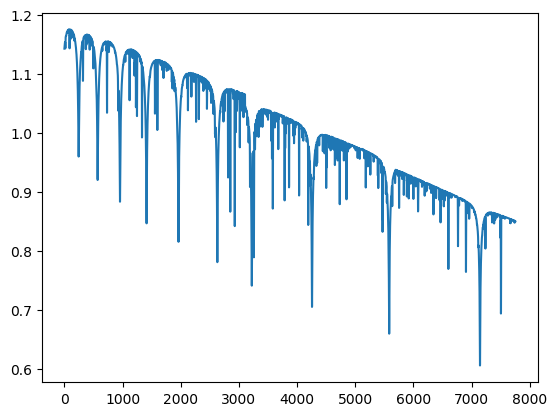

  0.544261 seconds (62.05 k allocations: 1.008 MiB)


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x2aaad6e1d908>

In [9]:
x = rand(7) .* (ulimits-steps-llimits) + llimits
plot(@time interpolate_spectrum(x))

### test inference 

In [ ]:
function test_inference()
    ul = ulimits - steps
    ll = llimits

    x = rand(7) .* (ul-ll) + ll
    println.(zip(param_names, x))
    f = interpolate_spectrum(x)
    err = ones(size(f)) * 0.01
    f .+= randn(size(f)) .* err

    χ2(params) = sum(((interpolate_spectrum(params) .- f) ./ err).^2)
    χ2grad(params) = sum( 2 * (interpolate_spectrum(params) .- f) .* interpolate_jacobi(params) ./ err.^2, dims=1)[:]
    χ2grad!(G, params) = G .= χ2grad(params) #Optim.jl wants a mutating gradient function

    x₀ = (ulimits+llimits)./2

    H = zeros(7, 7)
    @time χ2hessian!(H, x₀)
    @time res = optimize(χ2, χ2grad!, ll, ul, x₀, Fminbox(LBFGS()), Optim.Options(f_tol=1.))
    println(res.minimizer)

    res
end
test_inference()

# Notes

### Using the mutating version (`interpolate!`) is faster, even when you count the time to copy the subgrid.
```
using Interpolations
@time itp = scale(interpolate(grid[100, :, :, :, :, :, 1, 1], BSpline(Cubic(Reflect(OnGrid())))), ranges[1:5]...);
@time itp = scale(interpolate(grid[100, :, :, :, :, :, :, :], BSpline(Cubic(Reflect(OnGrid())))), ranges...);
@time begin
    subgrid = copy(grid[100, :, :, :, :, :, :, :])
    itp = scale(interpolate!(subgrid, BSpline(Cubic(Reflect(OnGrid())))), trim.(ranges)...)
end

  0.007908 seconds (15 allocations: 1.870 MiB, 61.03% gc time)
  0.134731 seconds (16 allocations: 90.267 MiB, 2.20% gc time)
  0.096192 seconds (17 allocations: 33.236 MiB)
```

Unfortunately, this results in the truncation of the interpolation domain one "step" inward of the original boundary.

### Header structure / parameter information
```
Pair{Any,Any}("LABEL", ["LOG10VDOP", "C", "N", "O Mg Si S Ca Ti", "METALS", "LOGG", "TEFF"])
Pair{Any,Any}("ULIMITS", [0.98227, 1.25, 2.5, 1.25, 1.25, 5.0, 6250.0])
Pair{Any,Any}("NPIX", 900)
Pair{Any,Any}("STEPS", [0.30103, 0.25, 0.5, 0.25, 0.25, 0.5, 250.0])
Pair{Any,Any}("LLIMITS", [-0.52288, -1.5, -0.5, -0.75, -2.5, 0.0, 3500.0])
```